Data has been selected from https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset

In [668]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, roc_auc_score, classification_report
from sklearn import set_config
from sklearn.compose import make_column_transformer

set_config(display="diagram")

In [669]:
shopping = pd.read_csv("data/online_shoppers_intention.csv")
shopping.head(2)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False


In [670]:
shopping.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

### There are no emply entries

In [671]:
shopping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

### Revenue is our target variable


In [672]:
shopping.Revenue.value_counts(normalize=True)

Revenue
False    0.845255
True     0.154745
Name: proportion, dtype: float64

Text(0.5, 1.0, 'count of target observations')

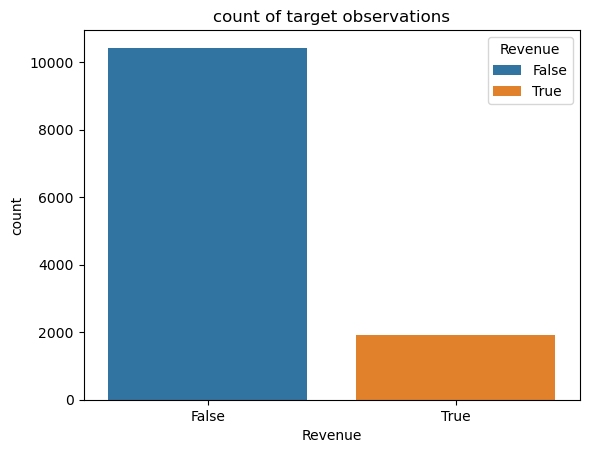

In [673]:
sns.countplot(data=shopping, x='Revenue', hue='Revenue')
plt.title('count of target observations')

In [674]:
X_train, X_test, y_train, y_test = train_test_split(shopping.drop('Revenue' , axis=1), shopping.Revenue, random_state=42, stratify=shopping.Revenue)
print(f'y_train value counts : {y_train.value_counts(normalize=True)}')
print(f'y_test value counts : {y_test.value_counts(normalize=True)}')


y_train value counts : Revenue
False    0.845247
True     0.154753
Name: proportion, dtype: float64
y_test value counts : Revenue
False    0.845281
True     0.154719
Name: proportion, dtype: float64


Baseline score of customer purchasing is 15%

In [675]:
categorical_columns = ['Month', 'VisitorType', 'Weekend']

transformer = make_column_transformer((OneHotEncoder(drop='if_binary'), categorical_columns), remainder=StandardScaler())
knn_pipe = Pipeline([('transform', transformer), ('knn', KNeighborsClassifier())])
knn_pipe.fit(X_train, y_train)
#shopping_preds = knn_pipe.predict(X_test)

#print(shopping_preds[:5])
knn_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Month', 'VisitorType',
                                                   'Weekend'])])),
                ('knn', KNeighborsClassifier())])

In [676]:
shopping_grid = GridSearchCV(knn_pipe, param_grid={'knn__n_neighbors' : range(1, 23, 2)}, scoring='accuracy') # by default it uses accuracy, options are accuracy, precision and recall
shopping_grid.fit(X_train, y_train)
shopping_preds = shopping_grid.best_estimator_.predict(X_test)
print(f' best n_neighbor param : {shopping_grid.best_params_["knn__n_neighbors"]}')
shopping_preds_proba = shopping_grid.best_estimator_.predict_proba(X_test)
#shopping_preds_proba


 best n_neighbor param : 11


In [677]:
print (f'Recall Score : {recall_score(y_test, shopping_preds, pos_label=True) : .3f}')
print(f'Precision Score : {precision_score(y_test, shopping_preds, pos_label=True) : .3f}')
print(f'Accuracy Score : {accuracy_score(y_test, shopping_preds) : .3f}')

Recall Score :  0.348
Precision Score :  0.683
Accuracy Score :  0.874


[[2529   77]
 [ 311  166]]


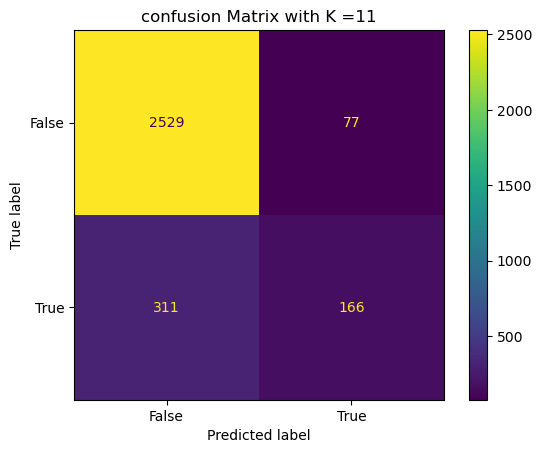

In [678]:
shopping_confusion_mat = ''
shopping_confusion_mat = confusion_matrix(y_test, shopping_preds, labels=[False, True])
print (shopping_confusion_mat)
disp = ConfusionMatrixDisplay(shopping_confusion_mat, display_labels=[False, True])
disp.plot()
plt.title('confusion Matrix with K =11')
plt.show()




We want to improve Recall significantly so we can focus our marketing efforts for customers who are really making purchases, at the same time we do not want Precision to go down too much by increasing False positive as we wasting resources by putting marking efforts on customers who are not making purchased from False positive group. 

To improve Recall, we will adjust threshold.  Following is threshold relationship with Recall and Precision.

In [679]:
### Creating Precision threshold function
def precision_thresh(predict_probs, y_test, thresh):
        """Given predicted probabilities and a threshold, this function
    computes predictions for the positive class at or above the threshold
    and returns the subesequent precision score for that thresholds predictions 
    against the test data.
    
    Parameters
    ----------
    predict_probs: type 'np.ndarray'
        1D NumPy array of probabilities for positive class
    y_test: type `np.ndarray`
        1D NumPy array of test label
    thresh: type `float`
        threshold for positive classification at or above
          
    Returns a float for precision value
    """
        preds = np.where(predict_probs >= thresh, True, False)
        return precision_score(y_test, preds, pos_label=True)

### function check
print(precision_thresh(shopping_preds_proba[:, 1] ,y_test, 0.1))
print(precision_thresh(shopping_preds_proba[:, 1] , y_test, 0.9))

0.36041666666666666
0.921875


In [680]:
### Creating recall threshold function
def recall_thresh(predict_probs, y_test, thresh):
    """Given predicted probabilities and a threshold, this function
    computes predictions for the positive class at or above the threshold
    and returns the subesequent recall score for that thresholds predictions 
    against the test data.
    
    Parameters
    ----------
    predict_probs: type 'np.ndarray'
        1D NumPy array of probabilities for positive class
    y_test: type `np.ndarray`
        1D NumPy array of test label
    thresh: type `float`
        threshold for positive classification at or above
          
    Returns a float for recall value
    """
    preds = np.where(predict_probs >= thresh, True, False)
    return recall_score(y_test, preds, pos_label=True)

### function check
print(recall_thresh(shopping_preds_proba[:, 1] ,y_test, 0.1))
print(recall_thresh(shopping_preds_proba[:, 1] , y_test, 0.9))

0.7253668763102725
0.12368972746331237


In [681]:
print(f'Classification report with default threshold of 0.5 and k = 11')
print (classification_report(y_test, shopping_preds))

Classification report with default threshold of 0.5 and k = 11
              precision    recall  f1-score   support

       False       0.89      0.97      0.93      2606
        True       0.68      0.35      0.46       477

    accuracy                           0.87      3083
   macro avg       0.79      0.66      0.69      3083
weighted avg       0.86      0.87      0.86      3083



In [682]:
thresholds = np.arange(0,1,0.1)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [683]:
results_df = pd.DataFrame({'threshold' : thresholds, 'precision' : [precision_thresh(shopping_preds_proba[:,1], y_test ,i) for i in thresholds], 'recall' : [recall_thresh(shopping_preds_proba[:,1], y_test, j) for j in thresholds]})
results_df

,threshold,precision,recall
0,0.0,0.154719,1.000000
1,0.1,0.360417,0.725367
2,0.2,0.472817,0.601677
3,0.3,0.545882,0.486373
4,0.4,0.627389,0.412998
5,0.5,0.683128,0.348008
6,0.6,0.715736,0.295597
7,0.7,0.768116,0.222222
8,0.8,0.777778,0.176101
9,0.9,0.921875,0.123690


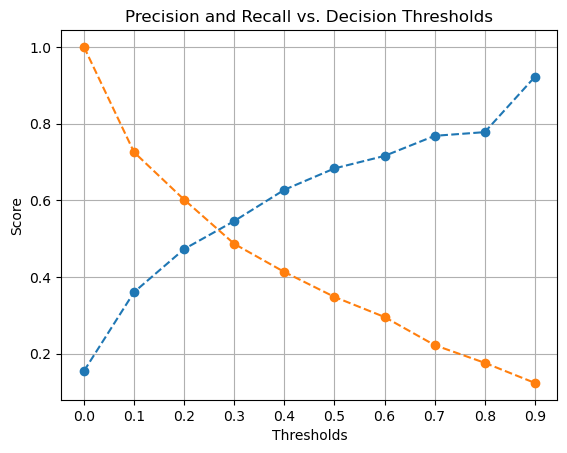

In [684]:
plt.plot(results_df['threshold'], results_df['precision'], '--o', label = 'precision')
plt.plot(results_df['threshold'], results_df['recall'], '--o', label = 'recall')
plt.xticks(thresholds)
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Decision Thresholds')
plt.grid();


 Boundaries : [0.   0.09 0.18 0.27 0.36 0.45 0.55 0.64 0.73 0.82 0.91 1.  ]
 Recall     : [1.   0.88 0.73 0.6  0.49 0.41 0.35 0.3  0.22 0.18 0.12 0.05 0.  ]
 Precision  : [0.15 0.26 0.36 0.47 0.55 0.63 0.68 0.72 0.77 0.78 0.92 0.92 1.  ]


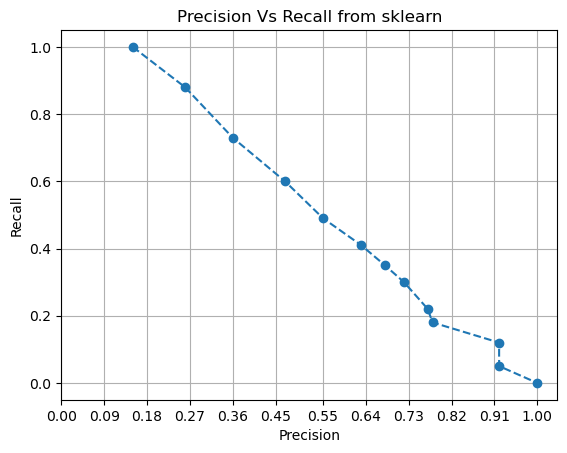

In [685]:
precision, recall, boundaries  =  '' ,'', ''

precision, recall, boundaries = precision_recall_curve(y_test, shopping_preds_proba[:,1], pos_label=True)
precision = np.round(precision, 2)
recall = np.round(recall, 2)
boundaries = np.round(boundaries, 2)

print(f' Boundaries : {boundaries}')
print(f' Recall     : {recall}')
print(f' Precision  : {precision}')
plt.plot(precision, recall, '--o')
plt.xticks(boundaries);
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Vs Recall from sklearn')
plt.grid()

### Gettomg confusion matrix with new threshold of 0.27



[[2286  320]
 [ 190  287]]


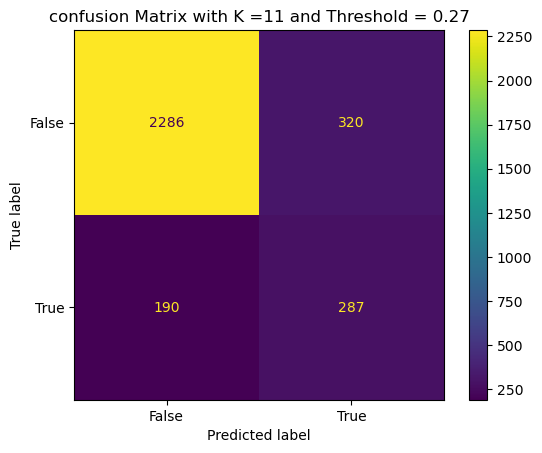

In [686]:
optimized_threshold = 0.27
optimized_shopping_preds = np.where(shopping_preds_proba[:,1] >= optimized_threshold, True, False)

optimized_shopping_confusion_mat = ''
optimized_shopping_confusion_mat = confusion_matrix(y_test, optimized_shopping_preds, labels=[False, True])
print (optimized_shopping_confusion_mat)
disp = ConfusionMatrixDisplay(optimized_shopping_confusion_mat, display_labels=[False, True])
disp.plot()
plt.title('confusion Matrix with K =11 and Threshold = 0.27')
plt.show()




In [687]:
print(f'Classification report with optimized threshold of {optimized_threshold} and k = 11')
print (classification_report(y_test, optimized_shopping_preds))

Classification report with optimized threshold of 0.27 and k = 11
              precision    recall  f1-score   support

       False       0.92      0.88      0.90      2606
        True       0.47      0.60      0.53       477

    accuracy                           0.83      3083
   macro avg       0.70      0.74      0.71      3083
weighted avg       0.85      0.83      0.84      3083



In [688]:
print(f'Optimized  Recall    Score with threshold {optimized_threshold} : {recall_score(y_test, optimized_shopping_preds, pos_label=True) : .3f}')
print(f'Optimized  Precision Score with threshold {optimized_threshold} : {precision_score(y_test, optimized_shopping_preds, pos_label=True) : .3f}')
print(f'Optimized  Accuracy  Score with threshold {optimized_threshold} : {accuracy_score(y_test, optimized_shopping_preds) : .3f}')

Optimized  Recall    Score with threshold 0.27 :  0.602
Optimized  Precision Score with threshold 0.27 :  0.473
Optimized  Accuracy  Score with threshold 0.27 :  0.835


### ROC curve           

### Running gridsearchCV again and scoring for roc_auc

In [689]:
shopping_grid_roc = GridSearchCV(knn_pipe, param_grid={'knn__n_neighbors' : range(1, 23, 2)}, scoring='roc_auc') # by default it uses accuracy, options are accuracy, precision and recall
shopping_grid_roc.fit(X_train, y_train)
shopping_preds_roc = shopping_grid_roc.best_estimator_.predict(X_test)
print(f' best n_neighbor param : {shopping_grid_roc.best_params_["knn__n_neighbors"]}')
shopping_preds_proba_roc = shopping_grid_roc.best_estimator_.predict_proba(X_test)
#shopping_preds_proba

 best n_neighbor param : 21


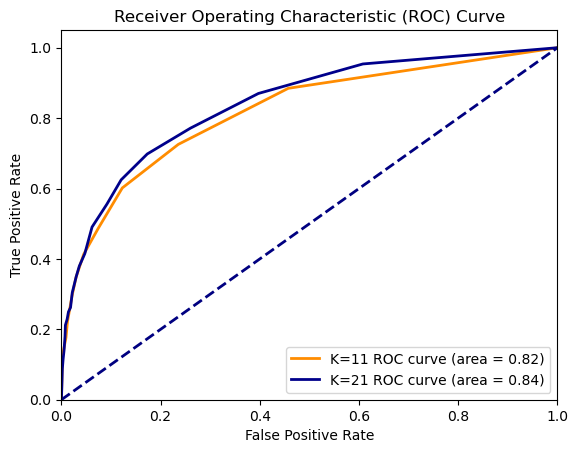

In [690]:
fpr, tpr, thresh_roc = '','',''
fpr_roc, tpr_roc, thresh_roc_roc = '','',''

fpr, tpr, thresh_roc = roc_curve(y_test, shopping_preds_proba[:,1], pos_label=True)
roc_auc = roc_auc_score(y_test,shopping_preds_proba[:,1])

fpr_roc, tpr_roc, thresh_roc_roc = roc_curve(y_test, shopping_preds_proba_roc[:,1], pos_label=True)
roc_roc_auc = roc_auc_score(y_test,shopping_preds_proba_roc[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr,tpr, color = 'darkorange', lw=2, label=f'K=11 ROC curve (area = {roc_auc :.2f})')
plt.plot(fpr_roc,tpr_roc, color = 'darkblue', lw=2, label=f'K=21 ROC curve (area = {roc_roc_auc :.2f})')
plt.plot([0,1], [0,1], color = 'navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


The provided ROC curve is a graphical representation of the performance of your classifier. Here are the key points to interpret this ROC curve:

1. **True Positive Rate (TPR)**: Also known as Sensitivity or Recall, it is plotted on the Y-axis. It represents the proportion of actual positives correctly identified by the model.

2. **False Positive Rate (FPR)**: It is plotted on the X-axis. It represents the proportion of actual negatives incorrectly identified as positives by the model.

3. **Diagonal Line (45-degree line)**: The dashed diagonal line represents a random classifier's performance. A model with a curve closer to this line indicates performance no better than random guessing.

4. **ROC Curve (Orange Line)**: The orange line represents the performance of your classifier at various threshold levels. The closer this curve is to the top-left corner, the better the classifier's performance.

5. **Area Under the Curve (AUC)**: The AUC value, 0.82 and 0.84 in this case, quantifies the overall ability of the model to discriminate between positive and negative classes. An AUC of 0.82 and 0.84 indicate good performance:
   - AUC = 1.0: Perfect classifier
   - AUC = 0.5: No discrimination (equivalent to random guessing)
   - AUC < 0.5: Worse than random guessing

In summary, the ROC curve and the AUC value of 0.82 and 0.84 suggest that this classifier performs well in distinguishing between the positive and negative classes. The curve being above the diagonal line and closer to the top-left corner indicates that the model has a good balance between sensitivity and specificity.